In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
43491,NaN,NaN,International,2020-09-11,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43492,NaN,NaN,International,2020-09-12,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43493,NaN,NaN,International,2020-09-13,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


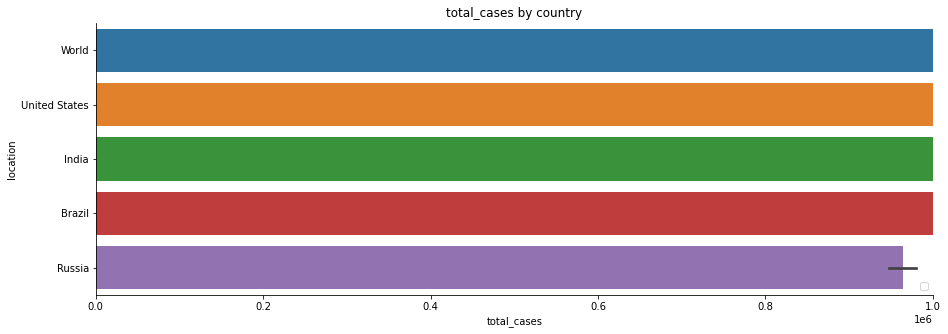

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


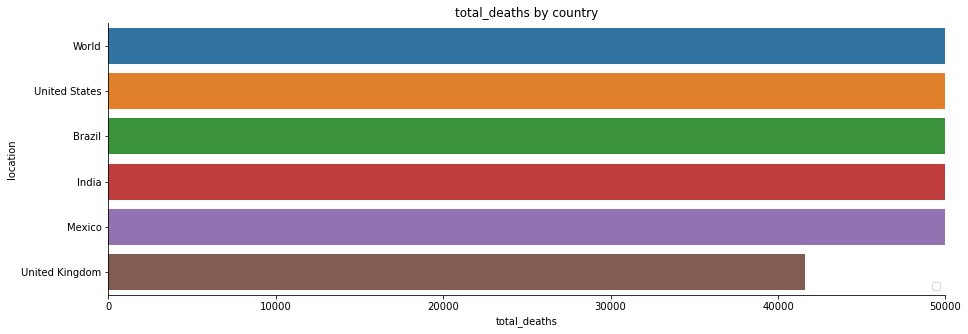

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


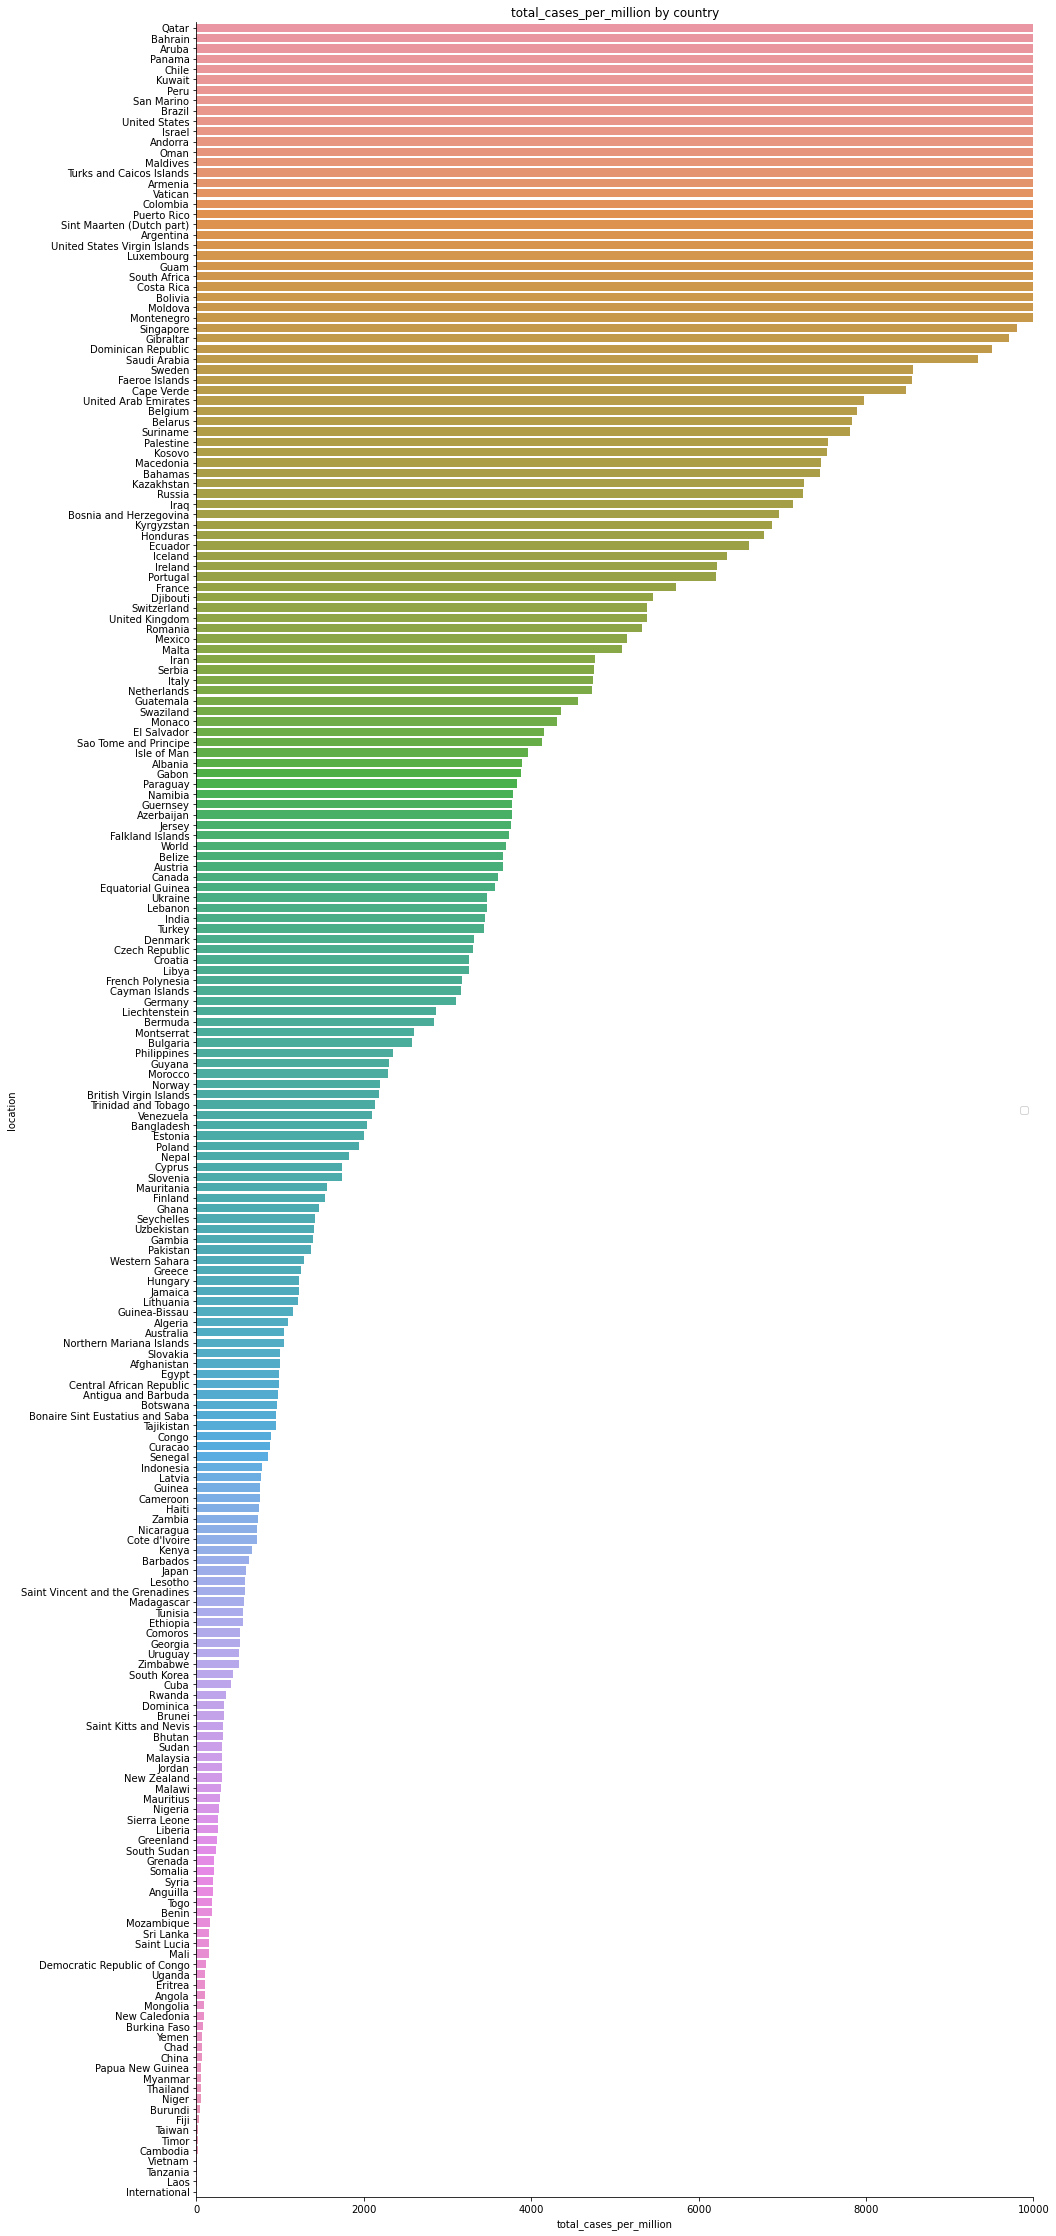

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


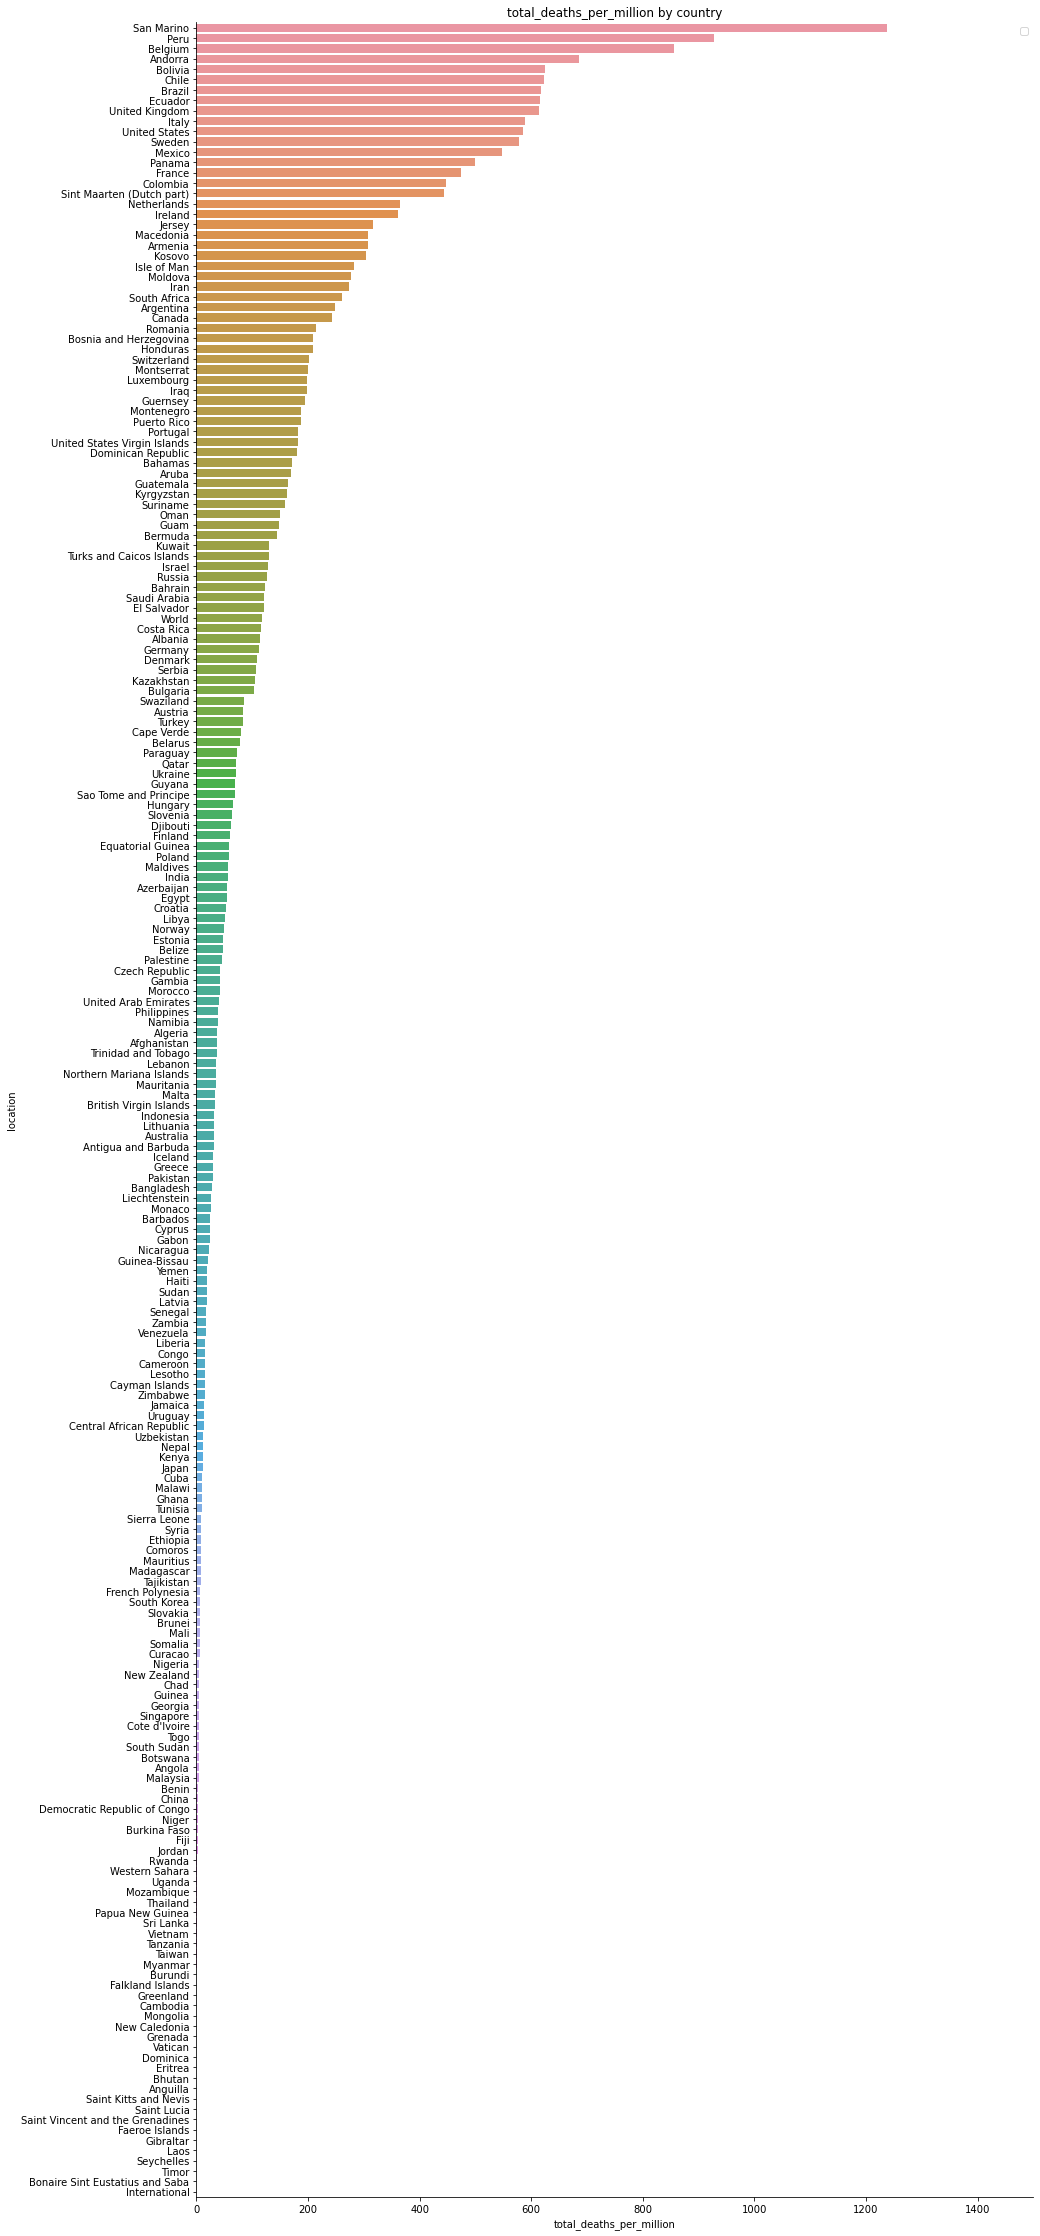

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

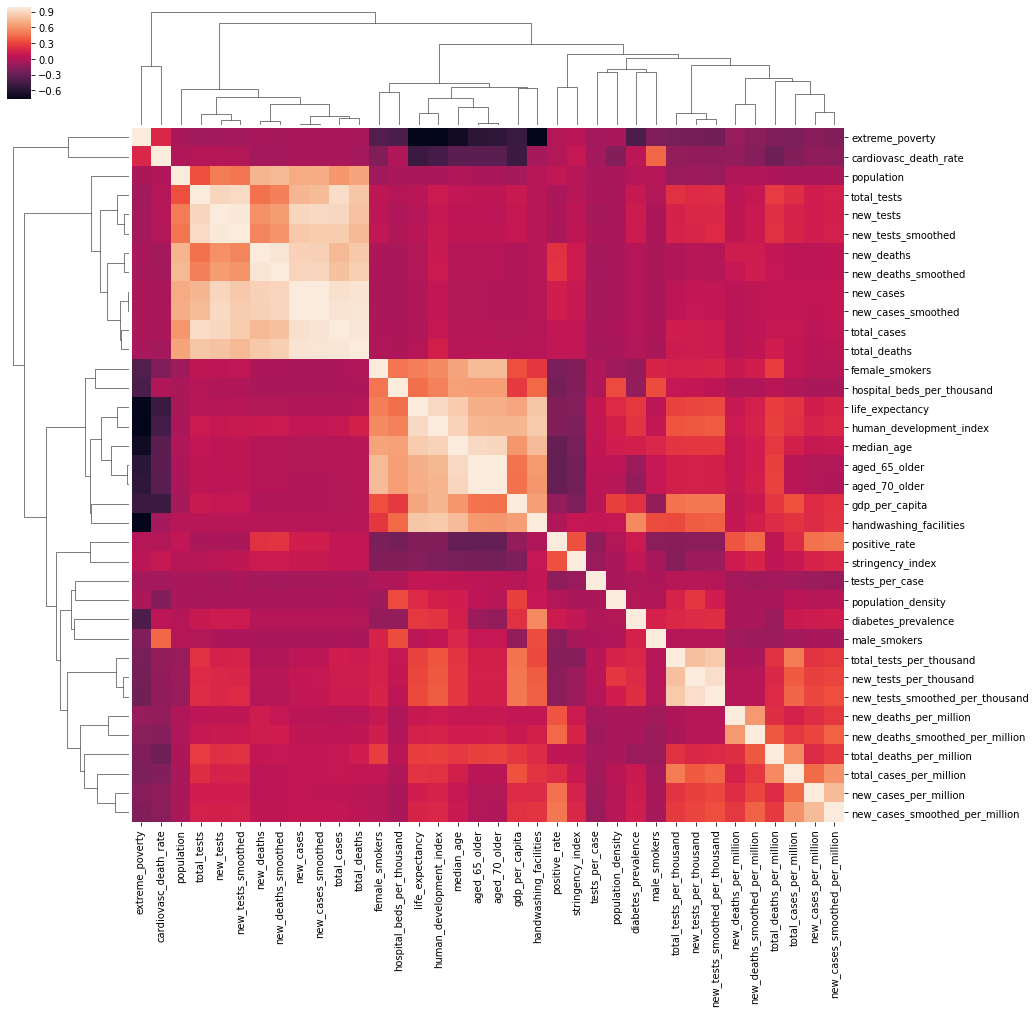

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998906086688682 (+/- 0.0013180073498439706)
Coef :  [1.03365600e+00 9.01326352e-05 9.27812202e-05]
3 Last_days :  [[28212728 28516744 28802775]]
Today :  28802775
Prediction + :  460392
Tomorow :  29263167
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996644933795779 (+/- 9.983942561273352e-05)
Coef :  [0.15799116 0.41393418 0.43841953]
3 Last_days :  [[910127 916005 920931]]
Today :  920931
Prediction + :  8794
Tomorow :  929725
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5556808820294021 (+/- 0.6242951050046532)
Coef :  [-0.76657187  0.78942548  0.98104804]
3 Last_days :  [[353944 363350 373911]]
Today :  373911
Prediction + :  8427
Tomorow :  382338
                                     
--------- Total Death -----------------
                                     
R^2: 0.9873145234484152 (+/- 0.008763816926815176)
Coef :  [-0.74928484  0.78873515  0.95953929]
3 Last_days :  [[30813 30893 30910]]
Today :  30910
Prediction + :  81
Tomorow :  30991
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9525417172856581 (+/- 0.03930703559587632)
Coef :  [-0.32790025 -0.01401889  1.33618456]
3 Last_days :  [[90127 90145 90168]]
Today :  90168
Prediction + :  24
Tomorow :  90192
                                     
--------- Total Death -----------------
                                     
R^2: -92.67873257744098 (+/- 132.37483993761515)
Coef :  [-0.07736242  0.01246057  1.05669228]
3 Last_days :  [[4733 4733 4734]]
Today :  4734
Prediction + :  5
Tomorow :  4739
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9457793861999995 (+/- 0.07551425176409429)
Coef :  [-0.81872901  0.89568366  0.92242784]
3 Last_days :  [[283180 284796 286297]]
Today :  286297
Prediction + :  1423
Tomorow :  287720
                                     
--------- Total Death -----------------
                                     
R^2: 0.9403907758550573 (+/- 0.06156274686719927)
Coef :  [-0.82365938  0.89719988  0.92550499]
3 Last_days :  [[35587 35597 35603]]
Today :  35603
Prediction + :  28
Tomorow :  35631
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5975032732229204 (+/- 0.5600286392398259)
Coef :  [-0.38509365  0.23220335  1.15732988]
3 Last_days :  [[554143 566326 566326]]
Today :  566326
Prediction + :  7457
Tomorow :  573783
                                     
--------- Total Death -----------------
                                     
R^2: -0.05856862907058188 (+/- 1.201685326218752)
Coef :  [-0.72908629  0.63673903  1.09133345]
3 Last_days :  [[29699 29747 29747]]
Today :  29747
Prediction + :  43
Tomorow :  29790
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9663401388047522 (+/- 0.04677955248547539)
Coef :  [0.07574787 0.46585247 0.47169317]
3 Last_days :  [[6397227 6445288 6486108]]
Today :  6486108
Prediction + :  76620
Tomorow :  6562728
                                     
--------- Total Death -----------------
                                     
R^2: 0.9952044777142396 (+/- 0.005550386785557995)
Coef :  [-0.45736262  0.69613281  0.76398524]
3 Last_days :  [[191789 193016 193701]]
Today :  193701
Prediction + :  1324
Tomorow :  195025
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9452504355020608 (+/- 0.07649876543121968)
Coef :  [-0.69263841  0.8336221   0.8595813 ]
3 Last_days :  [[358138 361677 365174]]
Today :  365174
Prediction + :  2732
Tomorow :  367906
                                     
--------- Total Death -----------------
                                     
R^2: 0.2817385603804096 (+/- 0.9722663223532849)
Coef :  [-0.76755517  0.83084669  0.9360118 ]
3 Last_days :  [[41608 41614 41623]]
Today :  41623
Prediction + :  38
Tomorow :  41661
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.3329896791628871 (+/- 0.942200924213854)
Coef :  [-0.78587485  0.85308564  0.93257894]
3 Last_days :  [[256850 258480 259428]]
Today :  259428
Prediction + :  1482
Tomorow :  260910
                                     
--------- Total Death -----------------
                                     
R^2: 0.2910093557991024 (+/- 0.9924454869276564)
Coef :  [-0.78704456  0.83996008  0.94632837]
3 Last_days :  [[9342 9347 9349]]
Today :  9349
Prediction + :  10
Tomorow :  9359
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9563781954250515 (+/- 0.05982147369783385)
Coef :  [0.27785873 0.36776031 0.36504193]
3 Last_days :  [[395488 397801 399940]]
Today :  399940
Prediction + :  3766
Tomorow :  403706
                                     
--------- Total Death -----------------
                                     
R^2: 0.9665095490668701 (+/- 0.046775248321264055)
Coef :  [0.06738571 0.47613768 0.4672924 ]
3 Last_days :  [[22798 22913 23029]]
Today :  23029
Prediction + :  241
Tomorow :  23270
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994829558485189 (+/- 0.0004895594951394393)
Coef :  [-0.68063966  0.82310028  0.85492195]
3 Last_days :  [[286455 288126 289635]]
Today :  289635
Prediction + :  1342
Tomorow :  290977
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994149295424912 (+/- 0.00036183815150227623)
Coef :  [-0.81149313  0.89323386  0.91595903]
3 Last_days :  [[6895 6951 6999]]
Today :  6999
Prediction + :  45
Tomorow :  7044
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9890721555716819 (+/- 0.009424169015059857)
Coef :  [-0.14738038  0.51821359  0.64277919]
3 Last_days :  [[4238446 4282164 4315687]]
Today :  4315687
Prediction + :  60217
Tomorow :  4375904
                                     
--------- Total Death -----------------
                                     
R^2: 0.4669648178547316 (+/- 0.7480621617947858)
Coef :  [-0.07406707  0.50505727  0.58011986]
3 Last_days :  [[129522 130396 131210]]
Today :  131210
Prediction + :  1475
Tomorow :  132685
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(28802775, 920931, 29263167, 929725),
 (373911, 30910, 382338, 30991),
 (286297, 35603, 287720, 35631),
 (566326, 29747, 573783, 29790),
 (6486108, 193701, 6562728, 195025),
 (90168, 4734, 90192, 4739),
 (365174, 41623, 367906, 41661),
 (259428, 9349, 260910, 9359),
 (399940, 23029, 403706, 23270),
 (289635, 6999, 290977, 7044),
 (4315687, 131210, 4375904, 132685)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-13,France,382338.0,0.0,30991.0,0.0,0.0,0.0
0,2020-09-13,China,90192.0,0.0,4739.0,0.0,0.0,0.0
0,2020-09-13,Italy,287720.0,0.0,35631.0,0.0,0.0,0.0
0,2020-09-13,Spain,573783.0,0.0,29790.0,0.0,0.0,0.0
0,2020-09-13,United States,6562728.0,0.0,195025.0,0.0,0.0,0.0
0,2020-09-13,World,29263167.0,0.0,929725.0,0.0,0.0,0.0
0,2020-09-13,United Kingdom,367906.0,0.0,41661.0,0.0,0.0,0.0
0,2020-09-13,Germany,260910.0,0.0,9359.0,0.0,0.0,0.0
0,2020-09-13,Iran,403706.0,0.0,23270.0,0.0,0.0,0.0
0,2020-09-13,Turkey,290977.0,0.0,7044.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")